### Interactive notebook to demo the interactive PPCA model

In [465]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
# from scipy.stats import invgamma, lognorm
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import seaborn as sns

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

from IPython.display import display, clear_output
from ipywidgets import Output, Label, VBox, HBox, Button
from ipywidgets import interact

from bqplot import (
    Axis, ColorAxis, LinearScale, LogScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ppca_model import MAP, generate
from common.dataset import dataset
import common.plot.simple_plot
from common.plot.simple_plot import SimpleFigure
from common.plot.scatter import imscatter, ellipse_scatter
from common.metric.dr_metrics import DRMetric

dataset.set_data_home('./data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [487]:
X_original, X, y = dataset.load_dataset('FASHION200')
learning_rate = 0.2
n_iters = 250

In [560]:
# run model the first time to have an init embdedding
losses, z2d_loc, z2d_scale, W, sigma = MAP(X, learning_rate, n_iters)

# global interactive data, let's call it 'state'
state = {
    'moved_points': {}, # reset moved points
    'debug_msg': 'Init state',
    'losses': losses,
    'z2d_loc': z2d_loc,
    'z2d_scale': z2d_scale
}

100%|██████████| 250/250 [00:02<00:00, 110.40it/s]


In [597]:
def show_top_error_class():
    from collections import Counter
    errors = np.linalg.norm(state['z2d_scale'], axis=1)

    K = int(X.shape[0] * 0.1)
    labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
                  7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

    top_K_ind = np.argpartition(errors, -K)[-K:]
    class_top_K = y[top_K_ind]
    cnt = Counter(class_top_K)
    count_top_K = []
    lbl_names = []
    for i in labels_map:
        count_top_K.append(cnt[i])
        lbl_names.append(f"{labels_map[i]} [{i}]")

    plt.barh(ind, count_top_K)
    plt.yticks(ind, lbl_names)
    plt.show()

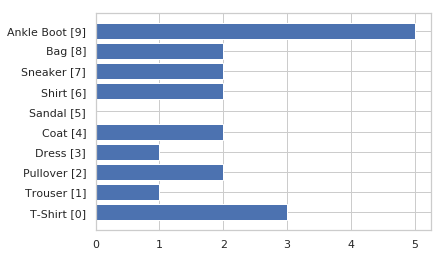

In [598]:
show_top_error_class()

(784,)


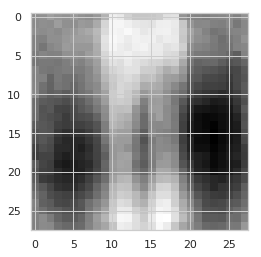

In [489]:
z = torch.tensor([[2.0, 3.0]])
x = generate(z, W, sigma, n_samples=1000)
print(x.shape)
x = x.reshape(28,28)
plt.imshow(x, cmap='gray')

In [490]:
# linear interpolate error range to bubble size
errors_as_size = np.interp(errors,
                           [np.min(errors), np.max(errors)],
                           [32, 512])

def log_interp1d(xx, yy, kind='linear'):
    '''https://stackoverflow.com/questions/29346292/logarithmic-interpolation-in-python'''
    import scipy as sp
    import scipy.interpolate
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

# interpolate errors in log scale
errors_as_size = log_interp1d(
    [np.min(errors), np.max(errors)],
    [32, 512]
)(errors)

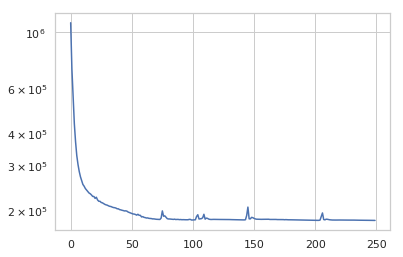

In [491]:
plt.semilogy(losses)

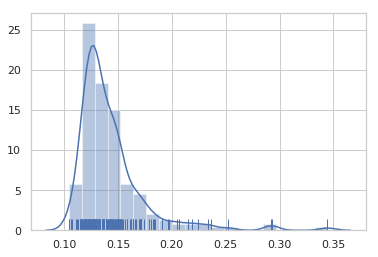

In [492]:
# plt.hist(errors, bins=20)
sns.distplot(errors, bins=20, kde=True, rug=True)

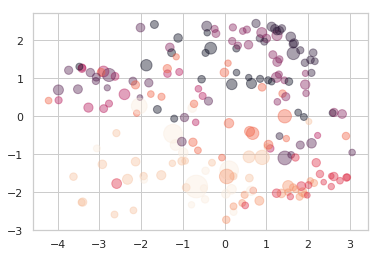

In [493]:
plt.scatter(
    x=z2d_loc[:, 0],
    y=z2d_loc[:, 1],
    c=y,
    s=errors_as_size,
    alpha=0.4
)

In [494]:
def scatter_with_images(ax, z2d, z2d_scale, original_data, labels_true):
    ax.scatter(z2d[:, 0], z2d[:, 1])
    imscatter(ax, z2d, data=original_data, zoom=.75, inverse_cmap=True,
              custom_cmap=None, labels_true=labels_true)
    # ellipse_scatter(ax, z2d, z2d_scale, labels_true)

In [550]:
# create base interactive scatter bqplot
sc_x = LinearScale()
sc_y = LinearScale()
sc_c = OrdinalColorScale(colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf'])
sc_size = LinearScale() # LinearScale()

def_tt = Tooltip(fields=['index', 'size'], formats=['', '.3f'])

scatt = Scatter(
    x=[], #z2d_loc[:, 0],
    y=[], #z2d_loc[:, 1],
    color=y,
    size=[], #errors,
    default_size=300, # max size of point
    # names=np.arange(z2d_loc.shape[0]),
    # display_names=False,
    default_opacities=[0.4],
    scales={'x': sc_x, 'y': sc_y, 'color': sc_c, 'size': sc_size},
    enable_move=True,
    tooltip=def_tt,
    unhovered_style={'opacity': 0.3},
    selected=[], # top_K_ind.tolist(),
    selected_style={'stroke': 'red','stroke-width':2, 'opacity':1.0},
)

def reset_scatt():
    scatt.x = []
    scatt.y = []

ax_x = Axis(scale=sc_x, grid_color='#EAECEE', grid_lines='dashed')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_color='#EAECEE', grid_lines='dashed')
ax_c = ColorAxis(scale=sc_c, orientation='vertical', side='right')

fig = Figure(marks=[scatt], axes=[ax_x, ax_y], fig_margin=dict(top=20, bottom=20, left=20, right=20))
fig.background_style = {'fill': 'White'}
fig.layout = {'width': '600px', 'height': '530px'}

In [551]:
# debug label to show some text
lbl = Label(color='green', font_size='18px', value=state['debug_msg'])

def drag_handler(scatter, value):
    # print("Drage here: ", value)
    p = value['point']
    point_id = int(value['index'])
    state['moved_points'][point_id] = [float(p['x']), float(p['y'])]
    lbl.value = str(state['moved_points'])

scatt.on_drag_end(drag_handler)

In [552]:
# output widget to hold the static matplotlib plot
out = Output(layout={'border': '0px solid black', 'width': '550px', 'display': 'inline-block'})

# static matplotlib scatter plot with images
_, ax = plt.subplots(1, 1, figsize=(7,7))
plt.close()

In [599]:
# define steps to run model and update graphs in an interactive manner
# all the data are shared between interactive components via the global state

def run_ippca():
    moved_points = state['moved_points']
    sigma_fix = 1e-4
    # print('Run interactive PPCA with moved points: ', moved_points, sigma_fix)
    
    losses, z2d_loc, z2d_scale, W, sigma = MAP(
        X, learning_rate, n_iters,
        moved_points=moved_points, sigma_fix=sigma_fix)
    # update global state, note to change each field of the global state dict
    # state['moved_points'] = {} # reset moved points
    state['debug_msg'] = 'Init state'
    state['losses'] = losses
    state['z2d_loc'] = z2d_loc
    state['z2d_scale'] = z2d_scale
    
    
def reset_imscatter():
    ax.clear()
    out.clear_output(wait=True)

    
def update_static_imscatter():
    z2d_loc = state['z2d_loc']
    z2d_scale = state['z2d_scale']
    with out:
        ax.clear()
        scatter_with_images(ax, z2d_loc, z2d_scale, X_original, y)
        clear_output(wait=True)
        plt.tight_layout()
        display(ax.figure)
        plt.close()
        

def update_scatter_bqplot():
    z2d_loc = state['z2d_loc']
    z2d_scale = state['z2d_scale']
    
    auc_rnx = DRMetric(X, z2d_loc).auc_rnx()
    print('AUC_RNX: ', auc_rnx)
    
    errors = np.linalg.norm(z2d_scale, axis=1)
    sns.distplot(errors, bins=20, kde=True, rug=True)
    
    # top_K_ind = np.argpartition(errors, -K)[-K:]
    scatt.x = z2d_loc[:,0]
    scatt.y = z2d_loc[:,1]
    scatt.size = errors
    scatt.selected = list(state['moved_points'].keys()) #top_K_ind.tolist()

In [600]:
# button to run iPPCA
btn_run = Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to re-run the model',
    icon='check'
)

btn_reset = Button(description='Reset', button_style='warning')

def show_avg_error():
    moved_ids = list(state['moved_points'].keys())
    z2d_scale = state['z2d_scale']
    errors = np.linalg.norm(z2d_scale, axis=1)
    avg_rest = (errors.sum() - errors[moved_ids].sum()) / (errors.shape[0] - errors[moved_ids].shape[0])
    print(f"AVG error for ALL={errors.mean()}, for REST={avg_rest}")
    
def rerun_model(btn):
    
    # show avg error of non-interactive points
    print('before moving: '); show_avg_error(); show_top_error_class()
    
    run_ippca()
    print('after moving: '); show_avg_error(); show_top_error_class()
    
    update_static_imscatter()
    update_scatter_bqplot()
    
def reset_gui(_):
    state['moved_points'] = {}
    state['debug_msg'] = 'Reset!'
    lbl.value = 'Reset!'
    reset_imscatter()
    out.clear_output()
    reset_scatt()
    
btn_run.on_click(rerun_model)
btn_reset.on_click(reset_gui)

AUC_RNX:  0.3554561403832155


before moving: 
AVG error for ALL=0.14323802292346954, for REST=0.14323801994323732


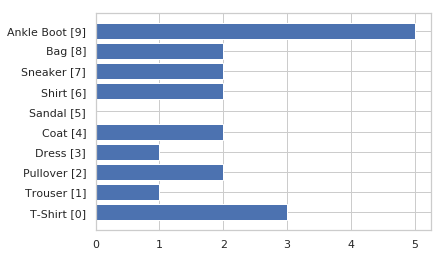

100%|██████████| 250/250 [00:02<00:00, 117.46it/s]


after moving: 
AVG error for ALL=0.14323802292346954, for REST=0.14323801994323732


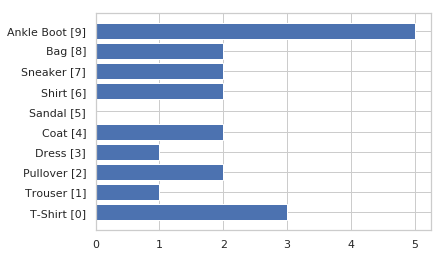

AUC_RNX:  0.3554561403832155


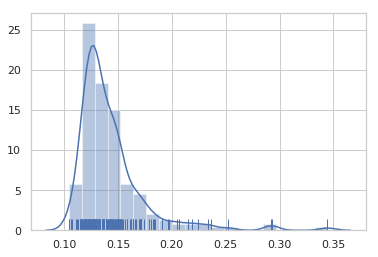

before moving: 
AVG error for ALL=0.14323802292346954, for REST=0.14012973162592673


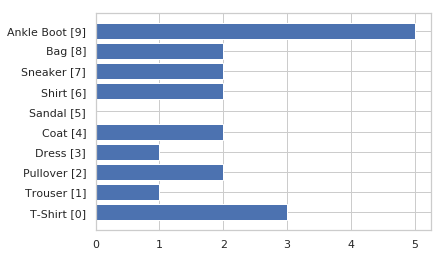

100%|██████████| 250/250 [00:02<00:00, 114.55it/s]


after moving: 
AVG error for ALL=0.17249228060245514, for REST=0.17415363934575295


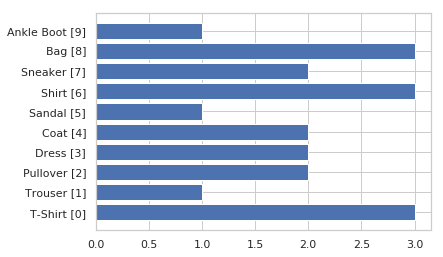

AUC_RNX:  0.35584155826117964


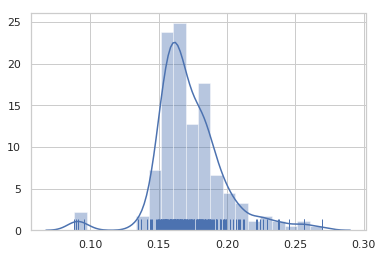

before moving: 
AVG error for ALL=0.17249228060245514, for REST=0.17249227523803712


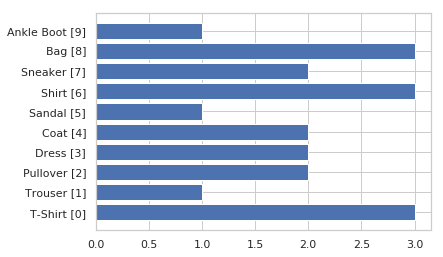

100%|██████████| 250/250 [00:02<00:00, 121.26it/s]


after moving: 
AVG error for ALL=0.14323802292346954, for REST=0.14323801994323732


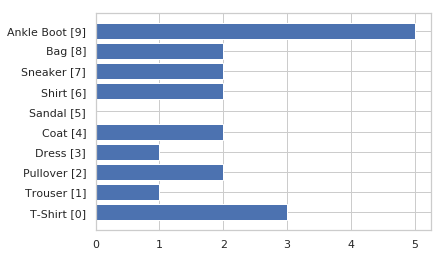

AUC_RNX:  0.3554561403832155


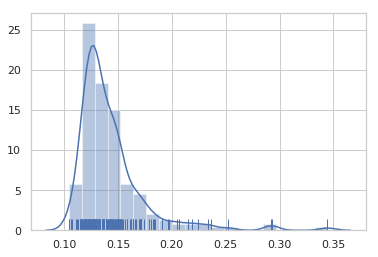

before moving: 
AVG error for ALL=0.14323802292346954, for REST=0.14337506920400292


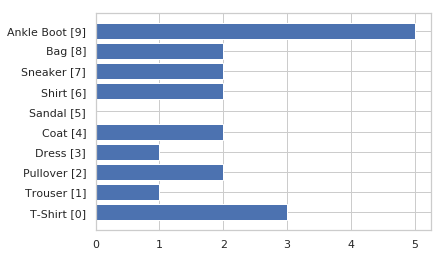

100%|██████████| 250/250 [00:02<00:00, 120.37it/s]


after moving: 
AVG error for ALL=0.11998126655817032, for REST=0.12016293496796579


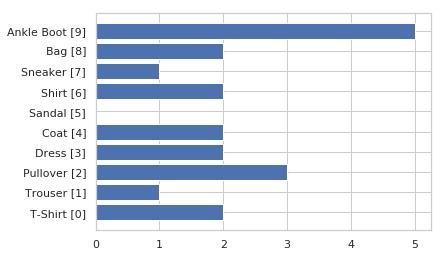

AUC_RNX:  0.3533898570057163


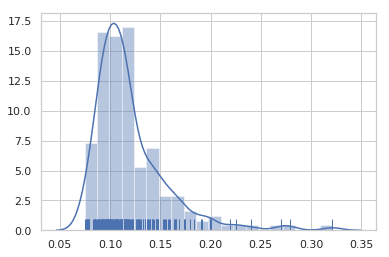

In [601]:
# feed init data to scatter bqplot and build static imscatter
reset_gui(_)
update_scatter_bqplot()
update_static_imscatter()
update_static_imscatter()

# whole layout
VBox([HBox([out, fig]),
      lbl,
      HBox([btn_run, btn_reset])
     ])